# Bayesian linear regression with variational inference (VI)

__Objective:__ manually implement the _Bayes by backprop_ algorithm for a linear regression problem.

Model: given data $(x_i, y_i)$ we want to model $y$ as a function of $x$ and we take
- Gaussian likelihood centered around a linear function of $x$:
$$
y \sim \mathcal{N}\left( y | \mu = a x + b, \sigma \right).
$$

- Unit Gaussian priors over the parameters $a$ and $b$:
$$
p(a) = p(b) = \mathcal{N}(0, 1)\,.
$$

- Gaussian variational distributions (approximating the posterior distributions for $a$ and $b$):
$$
\begin{array}{l}
q_{\mu_a, \sigma_a}(a) = \mathcal{N}\left( a | \mu_a, \sigma_a \right), \\
q_{\mu_b, \sigma_b}(b) = \mathcal{N}\left( b | \mu_b, \sigma_b\right).
\end{array}
$$

The parameters over which we optimize are $\mu_a$, $\sigma_a$, $\mu_b$, $\sigma_b$, expressed in terms of 4 weights $w_0, \ldots, w_3$ as
$$
\begin{array}{l}
\mu_a = w_0 \\
\sigma_a = \text{softplus}(w_1) \\
\mu_b = w_2 \\
\sigma_b = \text{softplus}(w_3)
\end{array}
$$

Following the Bayes by backprop algorithm, the loss function to optimize is
$$
\text{Loss} = \text{Loss}_\text{KL} + \text{Loss}_{NLL},
$$
with

$$
\begin{array}{l}
\text{Loss}_\text{KL} = \sum_{i\in \lbrace a, b \rbrace} \text{KL} \left[ \mathcal{N} (\theta_i | \mu_i, \sigma_i ) \vert\vert \mathcal{N}( \theta_i \vert\vert 0, 1 ) \right] = - \frac{1}{2} \left( 1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2 \right), \\
\text{Loss}_\text{NLL} = - \sum_{i\in \lbrace a, b \rbrace} \mathbb{E}_{\theta_i \sim \mathcal{N}(\mu_i, \sigma_i)} \left[ \log(p(D \vert \theta_i)) \right] \simeq - \frac{1}{N} \sum_{j=1}^{N} \log(p(D \vert \theta_i, j))
\end{array}
$$

and where $\theta_a \equiv a$, $\theta_b \equiv b$ and $\theta_{i, 1}, \ldots, \theta_{i, N}$ are $N$ samples of $\theta_i$ from its variational distribution given the current parameters $\mu_i$ and $\sigma_i$.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

sns.set_theme()

## Generate data

Text(0.5, 1.0, 'Data')

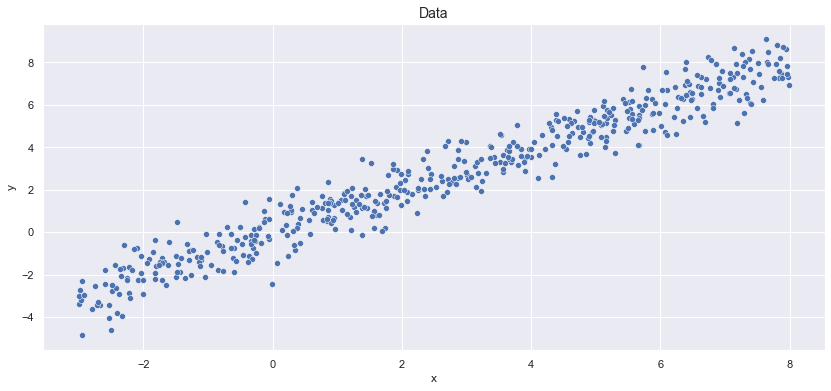

In [10]:
# Generate random datapoints normally distributed around a
# straight line.
n_datapoints = 500

x_data = tf.random.uniform(minval=-3., maxval=8., shape=(n_datapoints, 1))

a_true = 4.1
b_true = 1.2
sigma_data_true = 0.75

y_data = tf.squeeze(tfd.Normal(loc=x_data, scale=sigma_data_true).sample())


# Plot generated data.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_data[:, 0].numpy(),
    y=y_data.numpy()
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data', fontsize=14)

## Build the model

In [555]:
# Prior distributions.
priors = tfd.Normal(loc=[0., 0.], scale=[1., 1.])

# Weights parametrizing the variational distributions (with some
# initial values).
w0 = tf.Variable(0., name='w0')  # --> mu_a
w1 = tf.Variable(1., name='w1')  # --> softplus --> sigma_a
w2 = tf.Variable(0., name='w2')  # --> mu_b
w3 = tf.Variable(1., name='w2')  # --> softplus --> sigma_b

variational_distr = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)

In [560]:
# @tf.function
def compute_loss_kl(mu_a, sigma_a, mu_b, sigma_b):
    """
    """
    return (
        - 0.5 * (1 + tf.math.log(tf.square(sigma_a)) - tf.square(mu_a) - tf.square(sigma_a))
        - 0.5 * (1 + tf.math.log(tf.square(sigma_b)) - tf.square(mu_b) - tf.square(sigma_b))
    )

# Test.
compute_loss_kl(
    variational_distr.loc[0],
    variational_distr.scale[0],
    variational_distr.loc[1],
    variational_distr.scale[1]
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.17962837>

In [319]:
def build_likelihood(x_data, a_b_samples):
    """
    """
    return tfd.Independent(
            tfd.Normal(
            loc=a_b_samples[:, :1] * tf.transpose(x_data) + a_b_samples[:, 1:],
            scale=2.
        ),
        reinterpreted_batch_ndims=1
    )

# Test.
a_b_samples = variational_distr.sample(6)

build_likelihood(x_data, a_b_samples)

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[6] event_shape=[500] dtype=float32>

In [321]:
def nll(likelihood, y_data):
    """
    Returns the log likelihood of the dataset (one
    value computed as the sum of the log likelihood
    of each datapoint).
    
    Question: should we use an average over the datapoints
              instead?
    """
    return - likelihood.log_prob(y_data)


# Test.
nll(
    build_likelihood(x_data, a_b_samples),
    y_data
)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 2558.8843, 14266.613 ,  1537.8628,  1404.1309,  2168.1702,
        3933.6064], dtype=float32)>

In [376]:
# @tf.function
def compute_loss_nll(x_data, y_data, variational_distr, n_samples=1):
    """
    """
    # Generate samples for the parameters using the
    # reparametrization trick.
    # Shape: (n_samples, 2).
    a_b_samples = (
        variational_distr.loc
        + variational_distr.scale * tfd.Normal(loc=[0., 0.], scale=[1., 1.]).sample(n_samples)
    )
    
    # Compute a value for the NLL for each sample of a and b.
    nlls_a_b_samples =  tf.reduce_mean(nll(
        build_likelihood(x_data, a_b_samples),
        y_data
    ))
    
    # Return the MC approximation of the NLL (i.e. the average
    # over the samples of a and b.
    return tf.reduce_mean(nlls_a_b_samples)

# Test.
compute_loss_nll(x_data, y_data, variational_distr)

<tf.Tensor: shape=(), dtype=float32, numpy=1981.6022>

In [608]:
# @tf.function
def compute_total_loss(
        x_data,
        y_data,
        variational_distr
    ):
    """
    Note: we're using a loss NLL that is the SUM over samples, not
          the average, so it's orders of magnitude bigger than
          loss KL.
    """
    loss_kl = compute_loss_kl(
        variational_distr.loc[0],
        variational_distr.scale[0],
        variational_distr.loc[1],
        variational_distr.scale[1]
    )
    
    loss_nll = compute_loss_nll(x_data, y_data, variational_distr, n_samples=1)
    
    total_loss = loss_kl + loss_nll
    
    # print(f'Loss KL: {loss_kl} | Loss NLL: {loss_nll} | Total loss: {total_loss}')
    
    return total_loss


# Test.
compute_total_loss(
    x_data,
    y_data,
    variational_distr
)

<tf.Tensor: shape=(), dtype=float32, numpy=371203940.0>

## Model training

Train the model with gradient descent.

In [619]:
# Re-initialize weights (for experimenting).
w0 = tf.Variable(0.5, name='w0')  # --> mu_a
w1 = tf.Variable(1., name='w1')  # --> softplus --> sigma_a
w2 = tf.Variable(0.5, name='w2')  # --> mu_b
w3 = tf.Variable(1., name='w2')  # --> softplus --> sigma_b

variational_distr = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)


loss_history = [
    compute_total_loss(
        x_data,
        y_data,
        variational_distr
    ).numpy()
]

epoch = 0

In [620]:
epochs = 100

lr = 1e-4

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

print(f'Epoch: {epoch} | Loss: {loss_history[-1]}')

for i in range(epochs):
    with tf.GradientTape() as tape:
        variational_distr = tfd.Normal(
            loc=[w0, w2],
            scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
        )

        loss = compute_total_loss(
            x_data,
            y_data,
            variational_distr
        )

    grad = tape.gradient(loss, [w0, w1, w2, w3])

    optimizer.apply_gradients(zip(grad, [w0, w1, w2, w3]))
    
    loss_history.append(loss.numpy())
    
    epoch += 1
    
    print(f'Epoch: {epoch} | Loss: {loss_history[-1]}')
    
    
variational_distr_final = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)

Epoch: 0 | Loss: 8150.8671875
Epoch: 1 | Loss: 995.6381225585938
Epoch: 2 | Loss: 1055.441162109375
Epoch: 3 | Loss: 3417.0810546875
Epoch: 4 | Loss: 892.122802734375
Epoch: 5 | Loss: 6047.08837890625
Epoch: 6 | Loss: 4376.9267578125
Epoch: 7 | Loss: 3269.173095703125
Epoch: 8 | Loss: 2002.8851318359375
Epoch: 9 | Loss: 965.2135620117188
Epoch: 10 | Loss: 1061.7625732421875
Epoch: 11 | Loss: 1117.4046630859375
Epoch: 12 | Loss: 977.3203125
Epoch: 13 | Loss: 935.3790893554688
Epoch: 14 | Loss: 912.0855712890625
Epoch: 15 | Loss: 1128.960205078125
Epoch: 16 | Loss: 851.4674682617188
Epoch: 17 | Loss: 944.8073120117188
Epoch: 18 | Loss: 1353.4193115234375
Epoch: 19 | Loss: 934.4180908203125
Epoch: 20 | Loss: 884.60498046875
Epoch: 21 | Loss: 1459.991943359375
Epoch: 22 | Loss: 1700.780029296875
Epoch: 23 | Loss: 1341.7669677734375
Epoch: 24 | Loss: 2196.07958984375
Epoch: 25 | Loss: 1324.6820068359375
Epoch: 26 | Loss: 891.9931030273438
Epoch: 27 | Loss: 977.088134765625
Epoch: 28 | Loss:

Text(0.5, 1.0, 'Posterior distributions for $a$ and $b$')

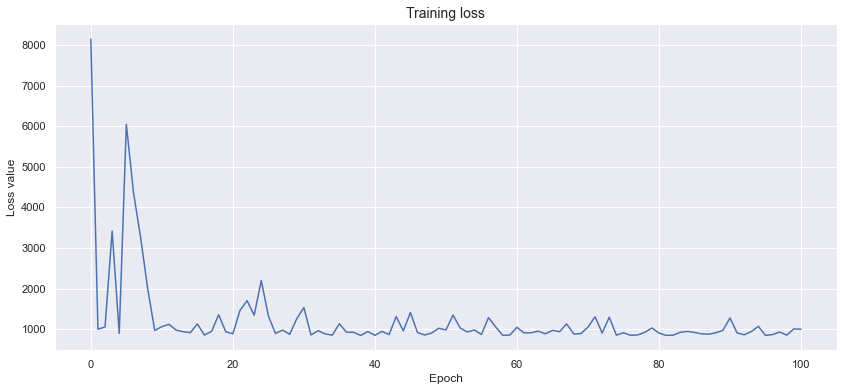

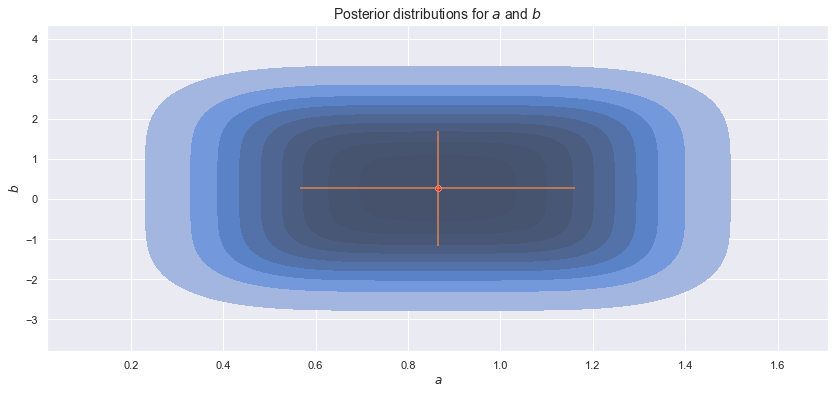

In [703]:
# Loss history
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(loss_history)),
    y=loss_history
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')


# 2-dimensional density plot for a and b.
fig = plt.figure(figsize=(14, 6))

# a_b_samples_final = variational_distr_final.sample(5000)
a_plot, b_plot = tf.meshgrid(
    tf.linspace(
        variational_distr_final.mean()[0] - 3. * variational_distr_final.stddev()[0],
        variational_distr_final.mean()[0] + 3. * variational_distr_final.stddev()[0],
        10
    ),
    tf.linspace(
        variational_distr_final.mean()[1] - 3. * variational_distr_final.stddev()[1],
        variational_distr_final.mean()[1] + 3. * variational_distr_final.stddev()[1],
        10
    )
)

a_b_samples_final = tf.stack(
    [
        tf.reshape(a_plot, a_plot.shape[0] * a_plot.shape[1]),
        tf.reshape(b_plot, b_plot.shape[0] * b_plot.shape[1])
    ],
    axis=1
)

sns.kdeplot(
    x=a_b_samples_final[:, 0].numpy(),
    y=a_b_samples_final[:, 1].numpy(),
    fill=True,
)

sns.scatterplot(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    color='red'
)

plt.errorbar(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    xerr=2. * variational_distr_final.stddev()[:1].numpy(),
    yerr=2. * variational_distr_final.stddev()[1:].numpy()
)

plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Posterior distributions for $a$ and $b$', fontsize=14)

In [709]:
def is_in_ellipse(point, maj_axis, min_axis, center):
    """
    """
    x_shifted = point[0] - center[0]
    y_shifted = point[1] - center[1]
    
    x_min = - maj_axis * tf.sqrt(1. - tf.square(x_shifted / min_axis))
    x_max = maj_axis * tf.sqrt(1. - tf.square(x_shifted / min_axis))
    
    y_min = - min_axis * tf.sqrt(1. - tf.square(y_shifted / maj_axis))
    y_max = min_axis * tf.sqrt(1. - tf.square(y_shifted / maj_axis))
    
    is_x_in_range = (x_shifted >= x_min) and (x_shifted <= x_max)
    is_y_in_range = (y_shifted >= y_min) and (y_shifted <= y_max)
    
    return (is_x_in_range and is_y_in_range)

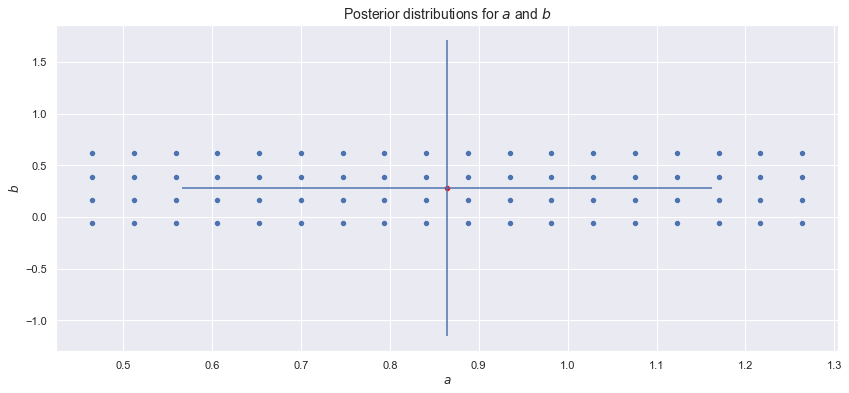

In [712]:
# IGNORE
# 2-dimensional level curve plot.
fig = plt.figure(figsize=(14, 6))


a_plot, b_plot = tf.meshgrid(
    tf.linspace(
        variational_distr_final.mean()[0] - 3. * variational_distr_final.stddev()[0],
        variational_distr_final.mean()[0] + 3. * variational_distr_final.stddev()[0],
        20
    ),
    tf.linspace(
        variational_distr_final.mean()[1] - 3. * variational_distr_final.stddev()[1],
        variational_distr_final.mean()[1] + 3. * variational_distr_final.stddev()[1],
        20
    )
)

a_b_samples_final = tf.stack(
    [
        tf.reshape(a_plot, a_plot.shape[0] * a_plot.shape[1]),
        tf.reshape(b_plot, b_plot.shape[0] * b_plot.shape[1])
    ],
    axis=1
)

a_b_samples_final = tf.stack(
    [
        p for p in list(a_b_samples_final)
        if is_in_ellipse(
            p,
            3. * variational_distr_final.stddev()[1],
            3. * variational_distr_final.stddev()[0],
            variational_distr_final.mean()
        )
    ],
    axis=0
)

sns.scatterplot(
    x=a_b_samples_final[:, 0].numpy(),
    y=a_b_samples_final[:, 1].numpy(),
)

sns.scatterplot(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    color='red'
)

plt.errorbar(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    xerr=2. * variational_distr_final.stddev()[:1].numpy(),
    yerr=2. * variational_distr_final.stddev()[1:].numpy()
)

plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Posterior distributions for $a$ and $b$', fontsize=14)